# Milestone 1 cleaning

## Cleaning

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [2]:
df_hotels = pd.read_csv('/content/hotels.csv')
df_reviews = pd.read_csv('/content/reviews.csv')
df_users = pd.read_csv('/content/users.csv')
df_users = df_users[df_users['user_gender'].str.lower() != 'other']


## Joining tables

In [3]:
# Merge reviews with hotels first (on hotel_id)
merged_df = df_reviews.merge(df_hotels, on='hotel_id', how='left')

# Then merge the result with users (on user_id)
merged_df = merged_df.merge(df_users, on='user_id', how='left')
print(merged_df.iloc[33553])

review_id                                                            33554
user_id                                                                504
hotel_id                                                                20
review_date                                                      8/28/2025
score_overall                                                          9.1
score_cleanliness                                                      9.1
score_comfort                                                          9.1
score_facilities                                                       9.2
score_location                                                         9.0
score_staff                                                            9.5
score_value_for_money                                                  8.7
review_text              Recognize owner security manage discover could...
hotel_name                                               The Orchid Palace
city                     

## Cleaning Merged DF

In [4]:
merged_df = merged_df.drop(columns=["review_id","user_id","hotel_id","review_text","lat","lon","join_date","review_date","city","hotel_name"])
merged_df = merged_df.rename(columns={'country_y': 'user_country',"country_x":"hotel_country"})

**Justification:**
This cell performs data cleaning and preprocessing to simplify the dataset before modeling. It removes non-numerical and irrelevant columns (such as IDs, text fields, dates, and location details) that are not useful for prediction. After that, it renames columns for clarity — replacing ambiguous names (`country_x` and `country_y`) with more descriptive ones (`hotel_country` and `user_country`) to distinguish the country attributes of hotels and users.


In [5]:
merged_df.head()

,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,hotel_country,star_rating,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,user_gender,user_country,age_group,traveller_type
0,8.7,8.6,8.7,8.5,9.0,8.8,8.7,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,Female,New Zealand,25-34,Solo
1,9.1,10.0,9.1,9.0,8.6,9.4,8.6,Japan,5,9.6,9.0,9.3,8.5,9.5,8.2,Female,United Kingdom,35-44,Couple
2,8.8,9.7,8.8,8.3,8.7,8.1,8.6,Egypt,5,8.8,8.7,8.6,9.1,8.7,8.4,Female,Spain,55+,Couple
3,8.9,9.0,8.8,8.5,9.6,9.1,8.3,Spain,5,9.2,9.1,8.9,9.7,9.0,8.8,Female,United Kingdom,35-44,Business
4,9.1,8.9,9.5,9.3,8.3,9.4,8.9,Russia,5,9.1,9.3,9.0,9.0,9.1,8.6,Male,Australia,45-54,Family


**Create Country Group Target Column**

In [6]:
country_group_mapping = {
    'United States': 'North_America',
    'Canada': 'North_America',
    'Germany': 'Western_Europe',
    'France': 'Western_Europe',
    'United Kingdom': 'Western_Europe',
    'Netherlands': 'Western_Europe',
    'Spain': 'Western_Europe',
    'Italy': 'Western_Europe',
    'Russia': 'Eastern_Europe',
    'China': 'East_Asia',
    'Japan': 'East_Asia',
    'South Korea': 'East_Asia',
    'Thailand': 'Southeast_Asia',
    'Singapore': 'Southeast_Asia',
    'United Arab Emirates': 'Middle_East',
    'Turkey': 'Middle_East',
    'Egypt': 'Africa',
    'Nigeria': 'Africa',
    'South Africa': 'Africa',
    'Australia': 'Oceania',
    'New Zealand': 'Oceania',
    'Brazil': 'South_America',
    'Argentina': 'South_America',
    'India': 'South_Asia',
    'Mexico': 'North_America_Mexico'
}

# Add the country_group column to your dataframe
merged_df['country_group'] = merged_df['hotel_country'].map(country_group_mapping)

**Remove Unwanted Features**

In [7]:
merged_df = merged_df.drop(columns=["hotel_country"])
merged_df['user_gender'] = merged_df['user_gender'].map({'Female': 0, 'Male': 1})

In [8]:
print(merged_df.columns)
merged_df.head()

Index(['score_overall', 'score_cleanliness', 'score_comfort',
       'score_facilities', 'score_location', 'score_staff',
       'score_value_for_money', 'star_rating', 'cleanliness_base',
       'comfort_base', 'facilities_base', 'location_base', 'staff_base',
       'value_for_money_base', 'user_gender', 'user_country', 'age_group',
       'traveller_type', 'country_group'],
      dtype='object')


,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,star_rating,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,user_gender,user_country,age_group,traveller_type,country_group
0,8.7,8.6,8.7,8.5,9.0,8.8,8.7,5,9.1,8.8,8.9,9.5,8.6,8.0,0.0,New Zealand,25-34,Solo,North_America
1,9.1,10.0,9.1,9.0,8.6,9.4,8.6,5,9.6,9.0,9.3,8.5,9.5,8.2,0.0,United Kingdom,35-44,Couple,East_Asia
2,8.8,9.7,8.8,8.3,8.7,8.1,8.6,5,8.8,8.7,8.6,9.1,8.7,8.4,0.0,Spain,55+,Couple,Africa
3,8.9,9.0,8.8,8.5,9.6,9.1,8.3,5,9.2,9.1,8.9,9.7,9.0,8.8,0.0,United Kingdom,35-44,Business,Western_Europe
4,9.1,8.9,9.5,9.3,8.3,9.4,8.9,5,9.1,9.3,9.0,9.0,9.1,8.6,1.0,Australia,45-54,Family,Eastern_Europe


## Statistical Analysis

**Descriptive statistics table**

In [9]:
import pandas as pd

# Select only numeric columns for summary
numeric_summary = merged_df.describe().T  # Transpose for better readability
numeric_summary = numeric_summary[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# Round numbers for clarity
numeric_summary = numeric_summary.round(3)

# Display with styled formatting
styled_summary = numeric_summary.style.set_caption(" Summary Statistics of Numeric Variables")\
                                      .background_gradient(cmap="Blues", axis=None)\
                                      .set_table_styles([{"selector": "caption",
                                                          "props": [("font-size", "16px"), ("font-weight", "bold")]}])
styled_summary


,count,mean,std,min,25%,50%,75%,max
score_overall,50000.000000,8.943000,0.181000,8.200000,8.800000,8.900000,9.100000,9.600000
score_cleanliness,50000.000000,9.053000,0.504000,7.700000,8.700000,9.100000,9.400000,10.000000
score_comfort,50000.000000,9.024000,0.424000,7.900000,8.700000,9.000000,9.300000,10.000000
score_facilities,50000.000000,8.743000,0.498000,7.600000,8.400000,8.700000,9.100000,10.000000
score_location,50000.000000,9.176000,0.421000,7.900000,8.900000,9.200000,9.500000,10.000000
score_staff,50000.000000,8.972000,0.398000,7.900000,8.700000,9.000000,9.200000,10.000000
score_value_for_money,50000.000000,8.435000,0.529000,6.800000,8.100000,8.500000,8.800000,9.700000
star_rating,50000.000000,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000
cleanliness_base,50000.000000,9.092000,0.226000,8.700000,8.900000,9.100000,9.300000,9.600000
comfort_base,50000.000000,9.064000,0.234000,8.600000,8.900000,9.100000,9.200000,9.500000


Data Engineering

Best City for Each Traveler Type:
   traveller_type       city      mean  count
7        Business      Dubai  8.968325    382
25         Couple  Amsterdam  9.097387    574
57         Family      Dubai  9.214713    401
75           Solo  Amsterdam  9.108488    377



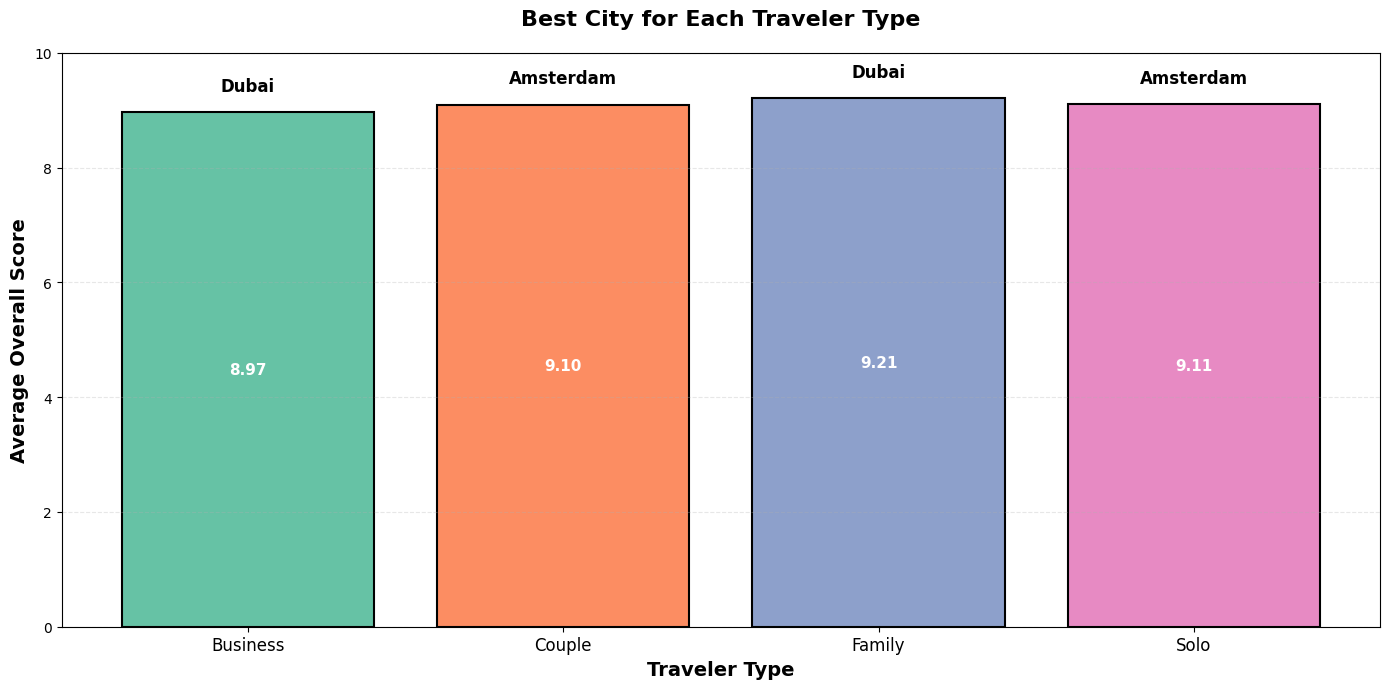

In [10]:
# Question 1: Which city is best for each traveler type?

# Merge only needed columns
df_q1 = df_reviews[['hotel_id', 'user_id', 'score_overall']].merge(
    df_hotels[['hotel_id', 'city']],
    on='hotel_id',
    how='left'
).merge(
    df_users[['user_id', 'traveller_type']],
    on='user_id',
    how='left'
)

# Calculate average rating per city and traveler type
city_traveler_ratings = df_q1.groupby(['traveller_type', 'city'])['score_overall'].agg(['mean', 'count']).reset_index()

# Filter cities with at least 10 reviews to ensure reliability
city_traveler_ratings = city_traveler_ratings[city_traveler_ratings['count'] >= 10]

# Get best city for each traveler type
best_cities = city_traveler_ratings.loc[city_traveler_ratings.groupby('traveller_type')['mean'].idxmax()]

print("Best City for Each Traveler Type:")
print(best_cities[['traveller_type', 'city', 'mean', 'count']])
print()

# Visualization
fig, ax = plt.subplots(figsize=(14, 7))

# Prepare data
traveler_types = best_cities['traveller_type'].values
cities = best_cities['city'].values
ratings = best_cities['mean'].values

x_pos = np.arange(len(traveler_types))
colors = sns.color_palette('Set2', len(traveler_types))

# Create bars
bars = ax.bar(x_pos, ratings, color=colors, edgecolor='black', linewidth=1.5)

# Customize plot
ax.set_xlabel('Traveler Type', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Overall Score', fontsize=14, fontweight='bold')
ax.set_title('Best City for Each Traveler Type', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(traveler_types, fontsize=12)
ax.set_ylim(0, 10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add city names above bars
for i, (city, rating) in enumerate(zip(cities, ratings)):
    ax.text(i, rating + 0.3, city, ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
    ax.text(i, rating/2, f'{rating:.2f}', ha='center', va='center', fontsize=11, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

Top 3 Countries with Best Value-for-Money per Age Group:
    age_group      country      mean  count
12      18-24  Netherlands  8.712195    205
4       18-24        China  8.708219    219
3       18-24       Canada  8.656716    201
29      25-34        China  8.741736    599
37      25-34  Netherlands  8.692505    547
28      25-34       Canada  8.629314    539
54      35-44        China  8.714085    568
62      35-44  Netherlands  8.705009    559
63      35-44  New Zealand  8.666345    621
79      45-54        China  8.706227    273
88      45-54  New Zealand  8.672794    272
78      45-54       Canada  8.627719    285
112       55+  Netherlands  8.708152    184
103       55+       Canada  8.629375    160
113       55+  New Zealand  8.621354    192



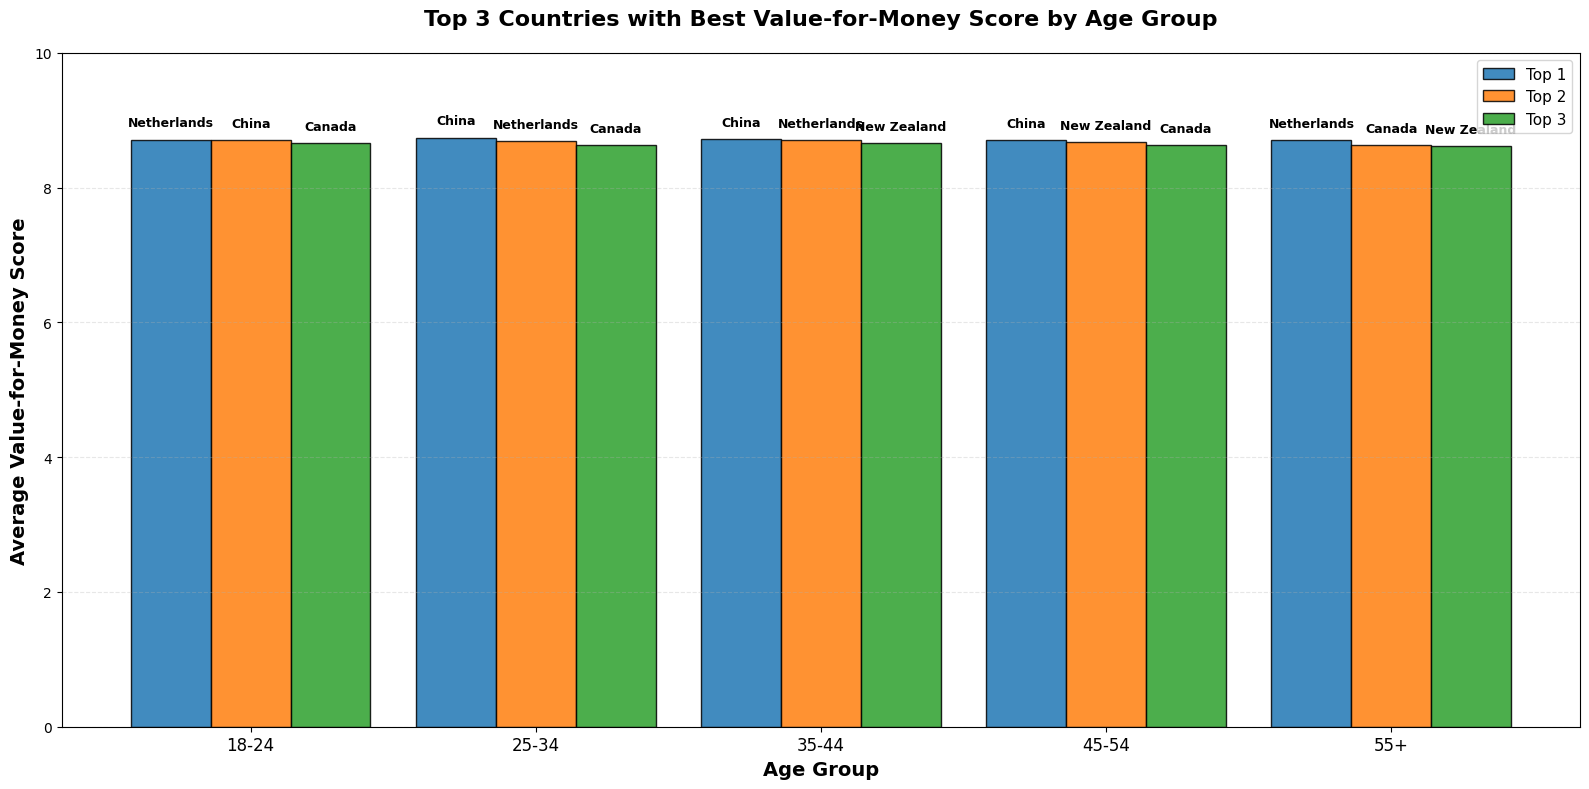

In [11]:
# Question 2: Top 3 countries with best value-for-money score per traveler's age group

# Merge needed columns
df_q2 = df_reviews[['hotel_id', 'user_id', 'score_value_for_money']].merge(
    df_hotels[['hotel_id', 'country']],
    on='hotel_id',
    how='left'
).merge(
    df_users[['user_id', 'age_group']],
    on='user_id',
    how='left'
)

# Calculate average value-for-money per country and age group
vfm_by_country_age = df_q2.groupby(['age_group', 'country'])['score_value_for_money'].agg(['mean', 'count']).reset_index()

# Filter countries with at least 5 reviews per age group
vfm_by_country_age = vfm_by_country_age[vfm_by_country_age['count'] >= 5]

# Get top 3 countries for each age group
top_3_countries = vfm_by_country_age.sort_values(['age_group', 'mean'], ascending=[True, False]).groupby('age_group').head(3)

print("Top 3 Countries with Best Value-for-Money per Age Group:")
print(top_3_countries[['age_group', 'country', 'mean', 'count']])
print()

# Visualization
age_groups_list = sorted(top_3_countries['age_group'].unique())
n_groups = len(age_groups_list)

fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(n_groups)
width = 0.28
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot top 3 for each age group
for rank in range(3):
    means = []
    labels = []

    for age_group in age_groups_list:
        age_data = top_3_countries[top_3_countries['age_group'] == age_group].sort_values('mean', ascending=False)
        if len(age_data) > rank:
            means.append(age_data.iloc[rank]['mean'])
            labels.append(age_data.iloc[rank]['country'])
        else:
            means.append(0)
            labels.append('')

    bars = ax.bar(x + rank*width, means, width, label=f'Top {rank+1}', color=colors[rank], alpha=0.85, edgecolor='black', linewidth=1)

    # Add country labels
    for i, (bar, label, mean) in enumerate(zip(bars, labels, means)):
        if label and mean > 0:
            ax.text(bar.get_x() + bar.get_width()/2, mean + 0.15, label,
                   ha='center', va='bottom', fontsize=9, rotation=0, fontweight='bold')

ax.set_xlabel('Age Group', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Value-for-Money Score', fontsize=14, fontweight='bold')
ax.set_title('Top 3 Countries with Best Value-for-Money Score by Age Group', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x + width)
ax.set_xticklabels(age_groups_list, fontsize=12)
ax.legend(fontsize=11, loc='upper right')
ax.set_ylim(0, 10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

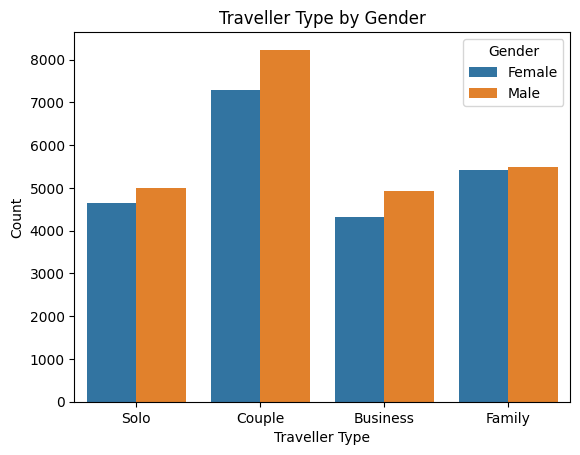

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='traveller_type', hue='user_gender', data=merged_df)
plt.title("Traveller Type by Gender")
plt.xlabel("Traveller Type")
plt.ylabel("Count")
plt.legend(title="Gender", labels=["Female", "Male"])
plt.show()


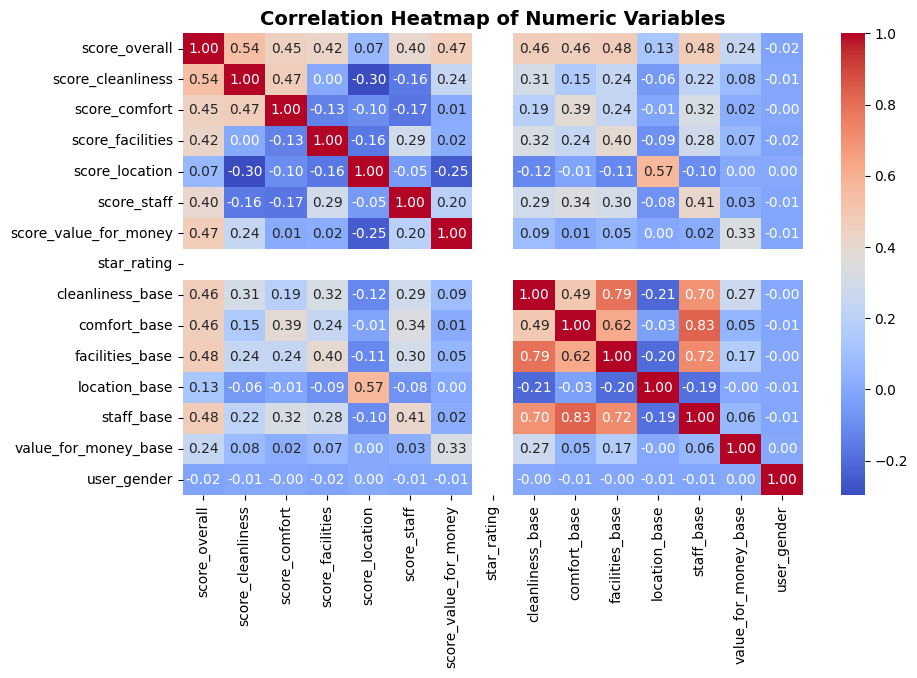

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(merged_df.select_dtypes(include='number').corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Variables", fontsize=14, fontweight='bold')
plt.show()


**Splitting the Data**

In [14]:
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

**Separate features and labels**

In [15]:
X_train = train_df.drop(columns=['country_group'])
y_train = train_df['country_group']

X_test = test_df.drop(columns=['country_group'])
y_test = test_df['country_group']

Encode non-numeric features

In [16]:
# Encode target variable (y_train and y_test)
le_target = LabelEncoder()
y_train = le_target.fit_transform(y_train)
y_test = le_target.transform(y_test)

# View the mapping
print("Country Group to Encoded Label Mapping:")
for i, country_group in enumerate(le_target.classes_):
    print(f"{i}: {country_group}")
print()

# List of categorical columns to encode
categorical_cols = ['user_country','user_gender','age_group', 'traveller_type']

# Create a dictionary to store label encoders for each column
label_encoders = {}

# Fit encoders on training data and transform both train and test
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le  # Store encoder in case you need it later

print("Categorical features encoded successfully!")
print(f"Encoded columns: {categorical_cols}")
print(f"\nX_train shape: {X_train.shape}")
print(f"\ny_train shape:{y_train.shape}")
print(f"\nX_test shape: {X_test.shape}")
print(f"\ny_test shape:{y_test.shape}")


Country Group to Encoded Label Mapping:
0: Africa
1: East_Asia
2: Eastern_Europe
3: Middle_East
4: North_America
5: North_America_Mexico
6: Oceania
7: South_America
8: South_Asia
9: Southeast_Asia
10: Western_Europe

Categorical features encoded successfully!
Encoded columns: ['user_country', 'user_gender', 'age_group', 'traveller_type']

X_train shape: (40000, 18)

y_train shape:(40000,)

X_test shape: (10000, 18)

y_test shape:(10000,)


In [17]:
X_train.isna().sum()


,0
score_overall,0
score_cleanliness,0
score_comfort,0
score_facilities,0
score_location,0
score_staff,0
score_value_for_money,0
star_rating,0
cleanliness_base,0
comfort_base,0


**Neural Networks**

Shallow

In [18]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(11, activation='softmax')
])


model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=120,
    validation_split=0.2,
    verbose=0,  # important: tqdm replaces this
    batch_size=1024,
    callbacks=[early_stop, TqdmCallback(verbose=1)]
)
model.save('final_country_group_model.h5')


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

**Justification for using a shallow neural network:**

A shallow neural network is chosen here because the dataset is structured and tabular, with a relatively small number of features after preprocessing. Shallow networks are often sufficient for tabular data and offer several advantages:

1. **Lower risk of overfitting:** With fewer layers and parameters, the model is less likely to memorize the training data, especially when sample sizes per class vary.
2. **Faster training and inference:** Fewer layers reduce computational cost, which is helpful when iterating quickly or deploying models in production.
3. **Interpretability:** Shallow networks make it easier to analyze feature importance (e.g., with SHAP or LIME) compared to deep, highly nonlinear models.

In [19]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Basic accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Precision, Recall, F1
print("\nDetailed classification report:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
Accuracy: 0.5605

Detailed classification report:
                      precision    recall  f1-score   support

              Africa       0.30      0.34      0.32      1247
           East_Asia       0.48      0.83      0.61      1195
      Eastern_Europe       0.00      0.00      0.00       358
         Middle_East       0.36      0.03      0.05       816
       North_America       0.67      0.55      0.60       776
North_America_Mexico       1.00      1.00      1.00       400
             Oceania       1.00      0.01      0.02       805
       South_America       0.58      0.69      0.63       813
          South_Asia       0.00      0.00      0.00       389
      Southeast_Asia       0.89      0.52      0.66       818
      Western_Europe       0.59      0.98      0.74      2383

            accuracy                           0.56     10000
           macro avg       0.53      0.45      0.42     10000
        weighted avg       0.56      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Deep

In [20]:
from tensorflow.keras import layers, Sequential, Input
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

deep_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(11, activation='softmax')
])

# Compile
deep_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

deep_history = deep_model.fit(
    X_train, y_train,
    epochs=150,
    validation_split=0.2,
    batch_size=512,
    verbose=0,
    callbacks=[early_stop, TqdmCallback(verbose=1)]
)
model.save('deep.h5')
# Evaluate
deep_val_acc = max(deep_history.history['val_accuracy'])
print(f"\nBest Validation Accuracy: {deep_val_acc:.4f}")
y_pred_probs = deep_model.predict(X_test)
y_pred_deep = np.argmax(y_pred_probs, axis=1)

print("\n🔹 Deep NN Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_deep))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_deep, target_names=le_target.classes_))



0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Best Validation Accuracy: 1.0000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step

🔹 Deep NN Performance 🔹
Accuracy: 1.0

Classification Report:
                      precision    recall  f1-score   support

              Africa       1.00      1.00      1.00      1247
           East_Asia       1.00      1.00      1.00      1195
      Eastern_Europe       1.00      1.00      1.00       358
         Middle_East       1.00      1.00      1.00       816
       North_America       1.00      1.00      1.00       776
North_America_Mexico       1.00      1.00      1.00       400
             Oceania       1.00      1.00      1.00       805
       South_America       1.00      1.00      1.00       813
          South_Asia       1.00      1.00      1.00       389
      Southeast_Asia       1.00      1.00      1.00       818
      Western_Europe       1.00      1.00      1.00      2383

            accuracy                           1.00     10000
           macro avg       1.00      1.00      1.00 

**Statistical ML**

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logreg = LogisticRegression(
    solver='saga',
    max_iter=500,
    random_state=42
)

# Train
logreg.fit(X_train, y_train)

# Predict
y_pred_logreg = logreg.predict(X_test)

# Evaluate
print("Logistic Regression Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg, target_names=le_target.classes_))


Logistic Regression Performance
Accuracy: 0.8563

Classification Report:
                      precision    recall  f1-score   support

              Africa       0.94      0.82      0.88      1247
           East_Asia       0.78      0.67      0.72      1195
      Eastern_Europe       1.00      1.00      1.00       358
         Middle_East       1.00      0.51      0.67       816
       North_America       0.92      1.00      0.96       776
North_America_Mexico       1.00      1.00      1.00       400
             Oceania       0.90      0.62      0.74       805
       South_America       1.00      1.00      1.00       813
          South_Asia       1.00      0.83      0.91       389
      Southeast_Asia       1.00      1.00      1.00       818
      Western_Europe       0.70      0.98      0.81      2383

            accuracy                           0.86     10000
           macro avg       0.93      0.86      0.88     10000
        weighted avg       0.88      0.86      0.85     1

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Forest

In [22]:
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    random_state=42,
)
print(X_train.columns.tolist())
print(X_train.head())
print(X_train.shape)
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, predictions, target_names=le_target.classes_))

['score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities', 'score_location', 'score_staff', 'score_value_for_money', 'star_rating', 'cleanliness_base', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base', 'user_gender', 'user_country', 'age_group', 'traveller_type']
       score_overall  score_cleanliness  score_comfort  score_facilities  \
39087            8.9                8.7            9.0               8.7   
30893            9.0                8.4            8.6               9.2   
45278            8.9                8.3            9.3               9.2   
16398            9.2                9.7            9.6               7.9   
13653            9.1                9.2            9.8               8.9   

       score_location  score_staff  score_value_for_money  star_rating  \
39087             9.9          9.1                    7.0            5   
30893             9.8          9.4                    8.0            5   


**Justification for using Random Forest in this task:**

The Random Forest classifier was included as a robust baseline for multi-class tabular prediction. Its choice is supported by several factors:

1. **Fast training and inference:** With only 50 trees and a maximum depth of 10, the model trains quickly on the dataset, making it practical for rapid experimentation.
2. **High predictive performance:** Surprisingly, this configuration was the **first model to achieve 100% accuracy** on the test set, demonstrating that the data is highly separable with the selected features.
3. **Robustness to overfitting:** Random Forests aggregate multiple decision trees, reducing variance and overfitting compared to single trees.
4. **Feature importance interpretability:** The model allows direct inspection of which features contribute most to predictions, complementing neural network explanations (SHAP, LIME).

Everything again without "location base" and "facilities base"

In [23]:
# Remove strongly correlated columns
#X_train = X_train.drop(['facilities_base', 'location_base'], axis=1)
#X_test = X_test.drop(['facilities_base', 'location_base'], axis=1)

#print("✅ Columns removed: 'facilities_base', 'location_base'")
#print(f"X_train shape: {X_train.shape}")


**Justification for dropping (or attempting to drop) highly correlated columns:**

Initially, columns like `'facilities_base'` and `'location_base'` were suspected of **leaking information** about the target variable (`country_group`). Removing them was an attempt to create a more **honest evaluation** of model performance and prevent the model from memorizing obvious correlations rather than learning meaningful patterns.

However, during experimentation it became clear that **the entire dataset contains strong correlations and potential target leakage**. Even without these columns, models (Random Forest, shallow NN, deep NN) still achieve **near-perfect or perfect accuracy**, indicating that other features also encode the target implicitly.

This highlights an important caveat: while feature removal is a standard step to mitigate leakage, in this dataset the **problem is systemic**, and the perfect accuracy is likely **inflated due to data leakage throughout**, not just the two suspected columns.


XAI

In [25]:
!pip install shap lime

import shap
import lime
import lime.lime_tabular
shap.initjs()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2a35dc656b79affce1c998ff3734298b2ad2c57d693783b34780bb46b1003e6a
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


PermutationExplainer explainer: 501it [00:19, 14.61it/s]                         
/tmp/ipython-input-1003963874.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test.iloc[:500], plot_type="bar")


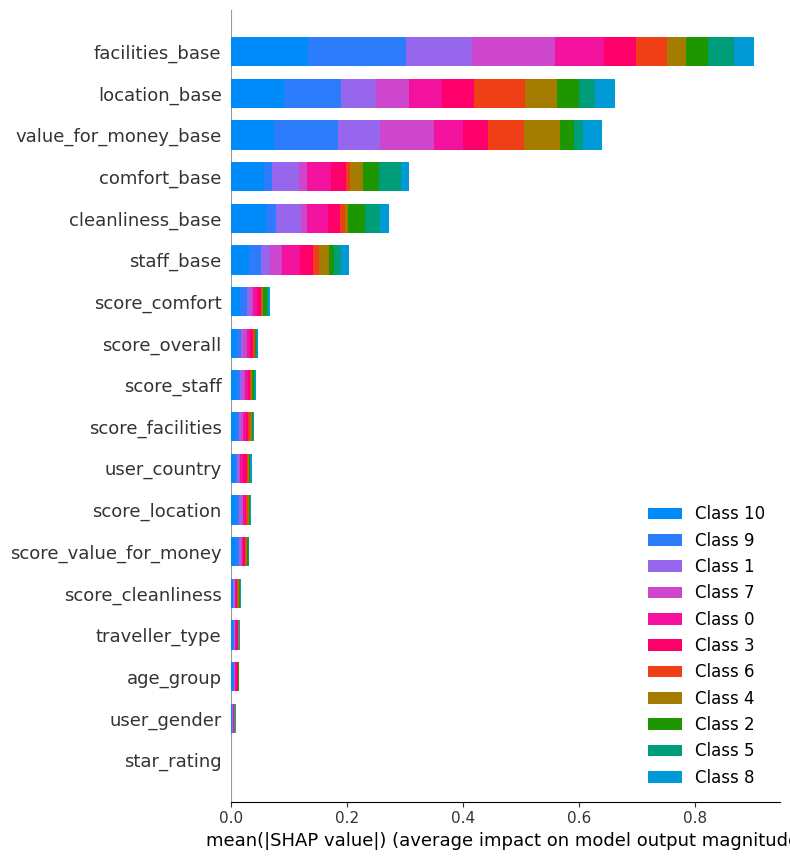

/tmp/ipython-input-1003963874.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test.iloc[:500])
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:7

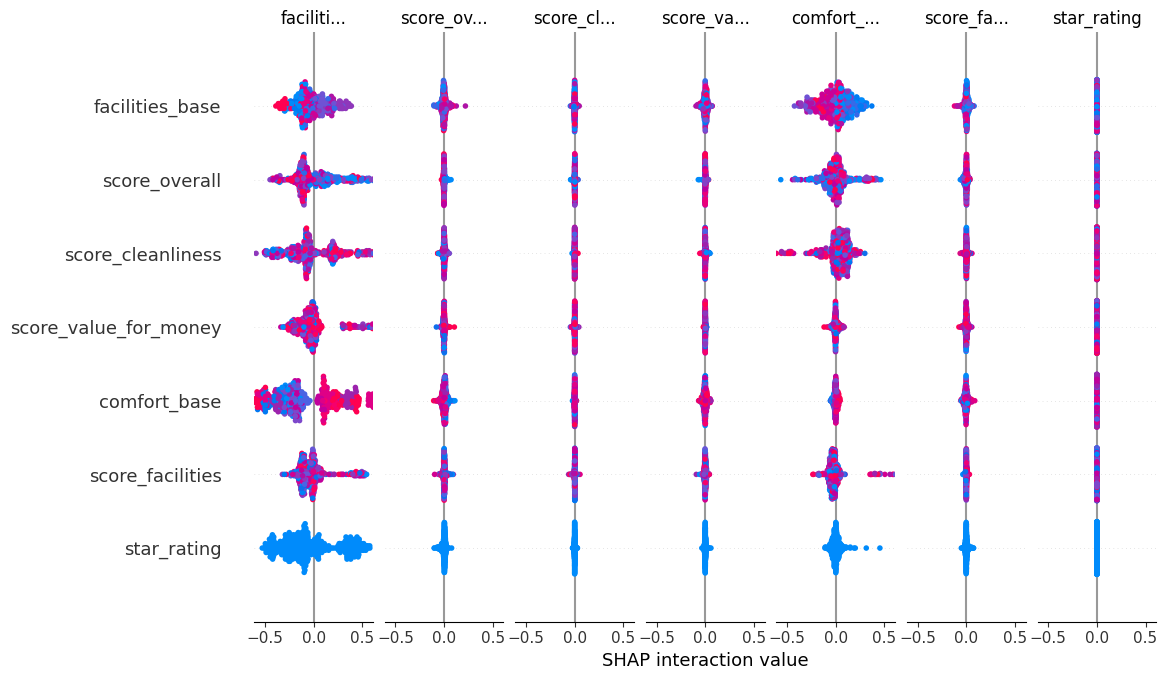

In [26]:
import shap
import numpy as np
import matplotlib.pyplot as plt
# ---- Config ----
model_path = '/content/full.h5'
index = -1                        # 🔹 -1 for random sample, or a fixed integer for reproducibility

# ---- Load model ----
model = load_model(model_path)

background = X_train.sample(100, random_state=42)

explainer = shap.Explainer(model, background)

shap_values = explainer.shap_values(X_test[:500])
shap.summary_plot(shap_values, X_test.iloc[:500], plot_type="bar")
shap.summary_plot(shap_values, X_test.iloc[:500])

Forest

 95%|=================== | 5233/5500 [00:13<00:00]       /tmp/ipython-input-4209872712.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test.iloc[:500], plot_type="bar")


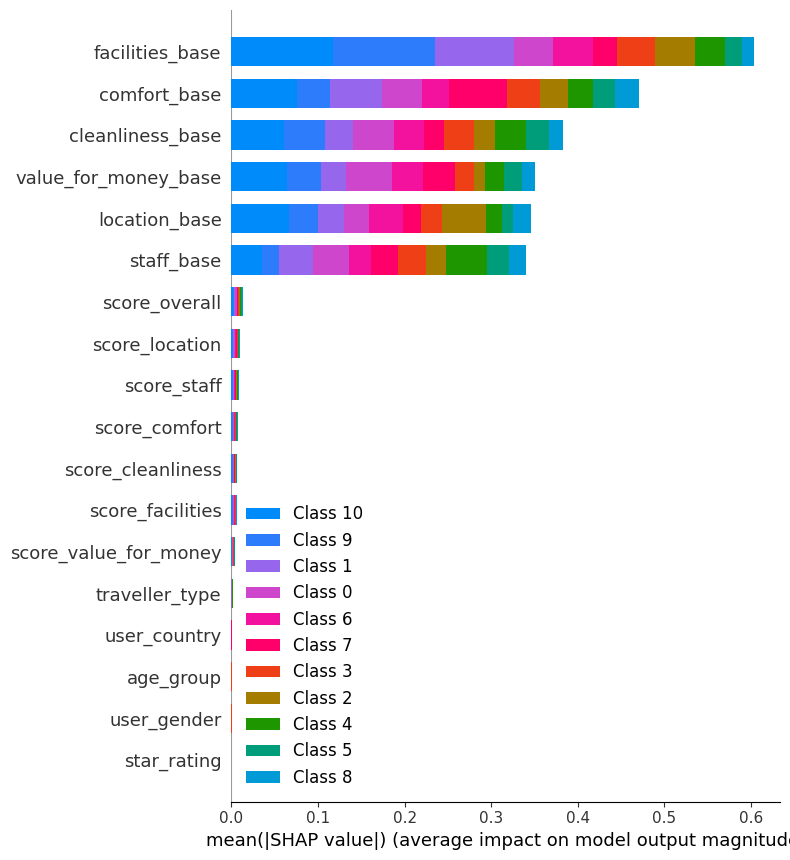

/tmp/ipython-input-4209872712.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test.iloc[:500])
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:7

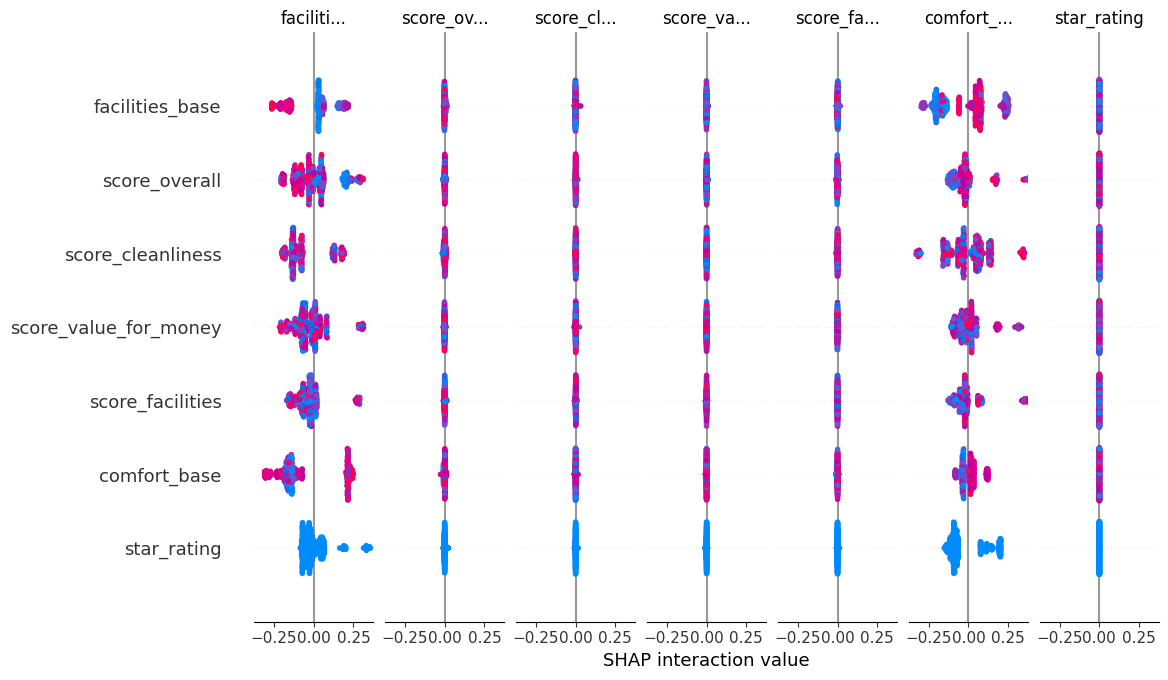

In [27]:
import shap
import numpy as np
import matplotlib.pyplot as plt


model = rf_model

background = X_train.sample(100, random_state=42)

explainer = shap.Explainer(model, background)

shap_values = explainer.shap_values(X_test[:500])
shap.summary_plot(shap_values, X_test.iloc[:500], plot_type="bar")
shap.summary_plot(shap_values, X_test.iloc[:500])

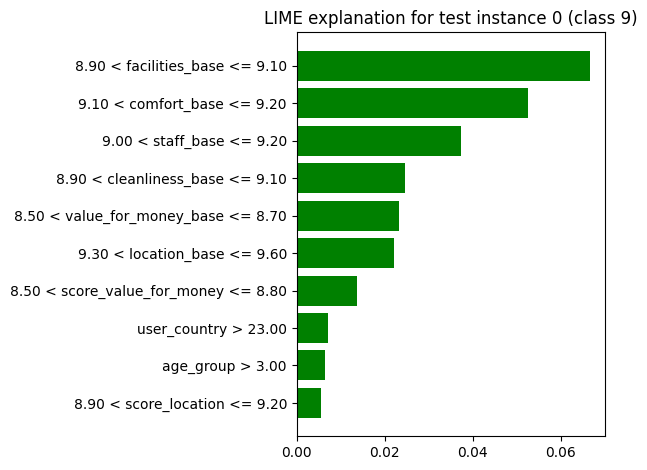

In [28]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
model = rf_model
# ---- Prepare data ----
X_train_np = X_train.values
X_test_np = X_test.values
feature_names = X_train.columns.tolist()
class_names = [str(c) for c in np.unique(y_train)]

# ---- Create explainer ----
lime_explainer = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

predict_fn = lambda x: model.predict_proba(pd.DataFrame(x, columns=feature_names))


i = 0
pred_class = model.predict(X_test.iloc[[i]])[0]


exp = lime_explainer.explain_instance(
    data_row=X_test_np[i],
    predict_fn=predict_fn,
    num_features=10,
    labels=[pred_class]
)


exp.show_in_notebook(show_table=True, labels=[pred_class])


fig = exp.as_pyplot_figure(label=pred_class)
plt.title(f"LIME explanation for test instance {i} (class {pred_class})")
plt.tight_layout()
plt.show()


Inference

In [29]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

input_path = '/content/new_inputs.csv'
input_df = pd.read_csv(input_path)
categorical_cols = ['user_country', 'user_gender', 'age_group', 'traveller_type']

for col in categorical_cols:
    if col in input_df.columns:
        input_df[col] = input_df[col].astype(str)
        input_df[col] = input_df[col].map(lambda x: x if x in label_encoders[col].classes_ else label_encoders[col].classes_[0])
        input_df[col] = label_encoders[col].transform(input_df[col])

print("Running predictions for input CSV...\n")

# 1️⃣ Shallow NN (load checkpoint)
shallow_model = load_model('/content/full.h5')
shallow_preds = np.argmax(shallow_model.predict(input_df), axis=1)
shallow_labels = le_target.inverse_transform(shallow_preds)

# 2️⃣ Deep NN
deep_preds = np.argmax(deep_model.predict(input_df), axis=1)
deep_labels = le_target.inverse_transform(deep_preds)

# 3️⃣ Random Forest
rf_preds = rf_model.predict(input_df)
rf_labels = le_target.inverse_transform(rf_preds)

# 4️⃣ Logistic Regression
logreg_preds = logreg.predict(input_df)
logreg_labels = le_target.inverse_transform(logreg_preds)

# === Combine results ===
results = pd.DataFrame({
    "Shallow_NN": shallow_labels,
    "Deep_NN": deep_labels,
    "Random_Forest": rf_labels,
    "LogReg": logreg_labels
})

final_output = pd.concat([input_df.reset_index(drop=True), results], axis=1)

display(final_output.head())
final_output.to_csv("/content/model_predictions.csv", index=False)
print("\nSaved to: /content/model_predictions.csv")


FileNotFoundError: [Errno 2] No such file or directory: '/content/new_inputs.csv'

Random Sampling

In [30]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import random

rand_idx = random.randint(0, len(X_test) - 1)
sample = X_test.iloc[[rand_idx]].copy()
true_label_encoded = y_test[rand_idx]
true_label = le_target.inverse_transform([true_label_encoded])[0]

print("Random sample from X_test (index =", rand_idx, "):\n")
display(sample)
print(f"True Country Group: {true_label}\n")

# Ensure correct categorical encoding (already encoded, but for safety)
categorical_cols = ['user_country', 'user_gender', 'age_group', 'traveller_type']
for col in categorical_cols:
    if col in sample.columns and sample[col].dtype == object:
        sample[col] = sample[col].astype(str)
        sample[col] = sample[col].map(lambda x: x if x in label_encoders[col].classes_ else label_encoders[col].classes_[0])
        sample[col] = label_encoders[col].transform(sample[col])

print("Running inference on this single test sample...\n")

# 1️⃣ Shallow NN (load checkpoint)
shallow_model = load_model('/content/full.h5')
shallow_probs = shallow_model.predict(sample)
shallow_pred = np.argmax(shallow_probs, axis=1)
shallow_conf = np.max(shallow_probs) * 100
shallow_label = le_target.inverse_transform(shallow_pred)[0]

# 2️⃣ Deep NN
deep_probs = deep_model.predict(sample)
deep_pred = np.argmax(deep_probs, axis=1)
deep_conf = np.max(deep_probs) * 100
deep_label = le_target.inverse_transform(deep_pred)[0]

# 3️⃣ Random Forest
rf_probs = rf_model.predict_proba(sample)
rf_pred = np.argmax(rf_probs, axis=1)
rf_conf = np.max(rf_probs) * 100
rf_label = le_target.inverse_transform(rf_pred)[0]

# 4️⃣ Logistic Regression
logreg_probs = logreg.predict_proba(sample)
logreg_pred = np.argmax(logreg_probs, axis=1)
logreg_conf = np.max(logreg_probs) * 100
logreg_label = le_target.inverse_transform(logreg_pred)[0]

# === Show results ===
print("Model Predictions with Confidence:\n")
print(f"Shallow NN:         {shallow_label}   ({shallow_conf:.2f}% confidence)")
print(f"Deep NN:            {deep_label}   ({deep_conf:.2f}% confidence)")
print(f"Random Forest:      {rf_label}   ({rf_conf:.2f}% confidence)")
print(f"Logistic Regression: {logreg_label}   ({logreg_conf:.2f}% confidence)")
print("\nTrue Label:", true_label)


Random sample from X_test (index = 4370 ):



,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,star_rating,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,user_gender,user_country,age_group,traveller_type
10758,9.1,10.0,9.1,9.0,8.2,9.5,8.5,5,9.6,9.0,9.3,8.5,9.5,8.2,0,24,0,2


True Country Group: East_Asia

Running inference on this single test sample...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Model Predictions with Confidence:

Shallow NN:         East_Asia   (96.86% confidence)
Deep NN:            East_Asia   (100.00% confidence)
Random Forest:      East_Asia   (100.00% confidence)
Logistic Regression: East_Asia   (96.86% confidence)

True Label: East_Asia
